# Deep Q Learning

In this exercise we will build a simple deep Q-learning agent from scratch. For this we need to look at the following tasks:
* How do we specify the model
* How do we calculate an action
* How do we sample episodes
* How do we train the model

We will develop this by implementing a class for the agent. We will use a package called jdc, that will allow us to split the implementation of a class over several cells.

We will be using torch for the implementation of the neural network. There is also a version of this exercise using keras, you can solve either one.

In this version of the exercise, you have to implement more :-)

In [1]:
!pip install jdc
!pip install ipywidgets
!pip install pyglet
!pip install pygame
!pip install gymnasium
import jdc
import numpy as np
import tqdm
import gymnasium as gym

from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import pyglet
import ipywidgets
from IPython import display

print(f'Matplotlib version: {matplotlib.__version__}')
print(f'Pyglet version: {pyglet.__version__}')
print(f'Ipywidgets version: {ipywidgets.__version__}')
%matplotlib inline



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Matplotlib version: 3.10.6
Pyglet version: 2.1.9
Ipywidgets version: 8.1.7


## Example: Cart Pole
We will use an environment from OpenAI for this exercise. The goal is to balance a pole by moving the attached cart to the left or to the right. As the pole should be balanced as long as possible, the reward for each time step is +1. An episode is done when the angle of the pole becomes too large.

The observation space gives some measurements about the pole, for example the angle. However, we actually do not need to know the specific details, as the neural network will just learn using the input.

The actions are to move the cart to the left or to the right.

In [2]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode='rgb_array')

print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')
print(f'Sample from the observation space: {env.observation_space.sample()}')

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Sample from the observation space: [ 2.3404944   0.5127314  -0.15680854 -1.9920869 ]


The environment has a render function that we can use to display the state. The parameter 'render_mode' is used to specify the mode. For standalone applications, we can use 'human' that will open a window. Here we get the image as an array and display it using matplotlib.

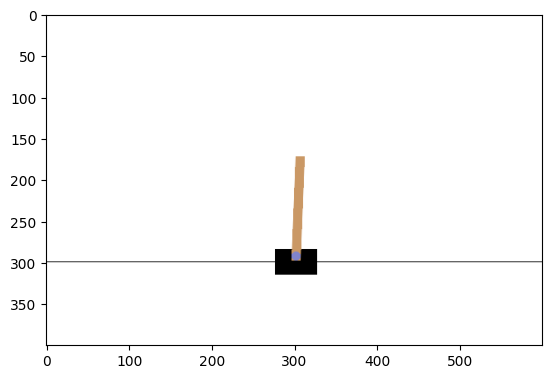

In [3]:
env.reset()
plt.imshow(env.render())
plt.show()

We can also try to render a sequence of images.


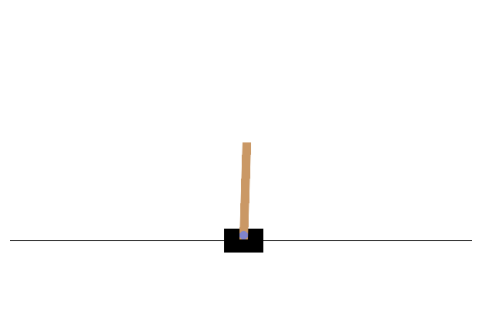

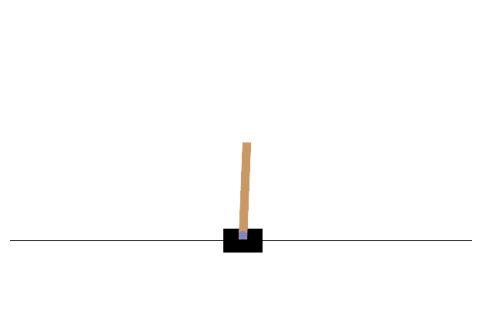

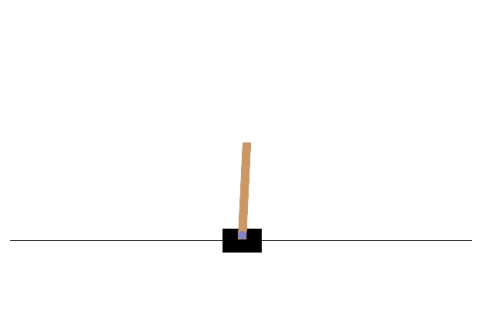

In [4]:
def display_environment(env):
    plt.figure(figsize=(6,4))
    plt.imshow(env.render())
    plt.axis('off')
    display.display(plt.gcf())
    # display.clear_output(wait=True)
    plt.close()

# Test the function with a few steps
env.reset()
for _ in range(3):
    env.step(env.action_space.sample())  # Take a random action
    display_environment(env)



## Build the model

We will define a class for the neural network (the model) that will be used for the agent. We will pass the number of observation values and the number of actions values as parameters.

The model must calculate the q function for each state. We will also need to access those values for evaluation.

Build a sequential model in torch using at least two dense layers.


In [5]:
class DQNetwork(nn.Module):
    def __init__(self, n_obs, n_action):
        super(DQNetwork, self).__init__()
        # generate a sequential model in a internal variable (for example self.fc)
        self.fc = nn.Sequential(
            nn.Linear(n_obs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )

    def forward(self, x):
        # forward should just call your model
        return self.fc(x)

    def q_values(self, obs):
        obs = torch.from_numpy(obs).float().unsqueeze(0)
        with torch.no_grad():
            q = self.forward(obs)
        return q.numpy()[0]

In [6]:
m = DQNetwork(env.observation_space.shape[0], env.action_space.n)
print(m)


obs_sample = env.observation_space.sample()
print(obs_sample)

# models xpect a batch of data, so we have to add a dimension
obs_batch = np.expand_dims(obs_sample, axis=0)
action_values = m.q_values(obs_batch)
assert action_values.shape == (1,2)

print(action_values)


DQNetwork(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
[-0.82875776 -0.9444368  -0.12727213 -0.56169045]
[[-0.02476686  0.07653295]]


## Agent class

Now we are ready to implement the agent class. Check the parameters and the descriptions as they will be used in the implementation.

The only step missing in the initialisation below is the optimizer and the loss function. There are different optimizers available, either standand SGD, Adam or RMSprob would be possible and should be initialized with the learning rate given in the parameters.

What is the loss function that we have to use?


In [7]:
class DQNAgent:
    def __init__(self, observation_space, action_space,
             gamma: float,
             epsilon: float, epsilon_decay: float, epsilon_min: float,
             learning_rate: float, training_frequency: int, target_update_frequency: int,
             tau : float, use_double_dqn: bool,
             batch_size: int, memory_size: int):
        """
        Initialise the agent.
        Args:
            observation_space: The observation space of the environment
            action_space: The action space of the environment
            gamma: The discount factor
            epsilon: The initial epsilon value for the epsilon-greedy policy
            epsilon_decay: The decay factor for the epsilon value
            epsilon_min: The minimal epsilon value after which it will not be decayed further
            learning_rate: The learning rate for the optimizer
            training_frequency: The frequency (in steps) of training the model
            target_update_frequency: The frequency (in steps) of updating the target model
            tau: weight of the new model in the target update 
            use_double_dqn: use double q learning
            batch_size: The batch size for training (sampled from the memory)
            memory_size: The size of the memory for storing experiences
        """
        self.observation_space = observation_space
        self.action_space = action_space
    
        # hyperparameters from parameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.training_frequency = training_frequency
        self.target_update_frequency = target_update_frequency
    
        self.use_double_dqn = use_double_dqn
        self.tau = tau

        self.nr_training_steps = 0
    
        # internal variables
        self.nr_steps = 0
    
        self.last_action = None
        self.last_obs = None
    
        # build the models
        self.model = DQNetwork(observation_space.shape[0], action_space.n)
        self.target_model = DQNetwork(observation_space.shape[0], action_space.n)

        
        self.optimizer = None
        self.loss = None 

        # generate the optimizer and loss function in the variables below

        self.optimizer = 
        self.loss = 


    def reset(self):
        """
        Reset the agent to the initial state
        """
        self.nr_steps = 0
        self.last_action = None
        self.last_obs = None
        self.nr_training_steps = 0
    
    def update_target_model(self):
        """
        Update the target model with the weights from the current model.
        """
        target_net_state_dict = self.target_model.state_dict()
        policy_net_state_dict = self.model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.tau + target_net_state_dict[key] * (1 - self.tau)
        self.target_model.load_state_dict(target_net_state_dict)

SyntaxError: invalid syntax (1239339752.py, line 60)

In [ ]:
q_agent = DQNAgent(env.observation_space, env.action_space,
                       gamma=0.99,
                       epsilon=0.9,
                       epsilon_min=0.03,
                       epsilon_decay=0.9999,
                       learning_rate=0.0005,
                       training_frequency=1,
                       target_update_frequency=2,
                       tau=0.005,
                       use_double_dqn=False,
                       batch_size=256,
                       memory_size=10000)



## Calculating actions

Calculating actions is done with an epsilon greedy policy. However, for evaluation it is often suitable to use the greedy policy instead. So we add a parameter `stochastic`, if it is True then the epsilon-greedy policy is used, if not the greedy policy is used.


In [ ]:
%%add_to DQNAgent
def calculate_action(self, obs, stochastic: bool = True) -> int:
    """
    Calculate the action for the given observation.
    Args:
        obs: the observation
        stochastic: whether to use a stochastic (epsilon greedy) policy or not
    Returns:
        the action
    """
    if not stochastic or np.random.rand() > self.epsilon:
        # calculate greedy action
        with torch.no_grad():
            action_value = self.model.q_values(obs)
        return np.argmax(action_value)
    else:
        # calculate random action
        return self.action_space.sample()

In [ ]:
agent = DQNAgent(env.observation_space, env.action_space,
                       gamma=0.99,
                       epsilon=0.9,
                       epsilon_min=0.03,
                       epsilon_decay=0.9999,
                       learning_rate=0.0005,
                       training_frequency=1,
                       target_update_frequency=2,
                       tau=0.005,
                       use_double_dqn=False,
                       batch_size=256,
                       memory_size=10000)
obs = env.observation_space.sample()
a = agent.calculate_action(obs)
assert env.action_space.contains(a)
a = agent.calculate_action(obs, stochastic=False)
assert env.action_space.contains(a)

## Add the steps

Next we will add two step function as in the previous implementations of an agent last week. If the reward is equal to None, then this is the first step in the environment.

The `step` method is called for all  steps. In the step method we need to
* Save the current experience (S, A, R, S', done) in the memory.
* Calculate the next action
* Save action and observation for next step
* train the model every couple of steps
* update the target model every couple of steps

You have to fill in the code for the first three items.


In [ ]:
%%add_to DQNAgent

def step(self, obs, reward: float, done: bool):

    if reward == None:
        self.last_obs = obs
        self.last_action = self.calculate_action(obs)
        return self.last_action        

    # now we have a new state and reward from the last action and can add that to the buffer (memory)

    # so the buffer is (S, A, R, S', done)
    self.memory.append((self.last_obs, self.last_action, reward, obs, done))

    # calculate the next action
    self.last_action = self.calculate_action(obs)
    self.last_obs = obs

    self.nr_steps += 1

    if self.nr_steps % self.training_frequency == 0:
        self.train_model()

    if self.nr_steps % self.target_update_frequency == 0:
        self.update_target_model()

    return self.last_action

## Train the model function

The last thing to do is now to train the model. For this we have to 
* Sample from the memory to get a batch of observations, actions, rewards, next observations and dones
* Calculate a better estimate for the q values of the current observation using q-learning
* Fit the model to the updated values using gradient descend on the loss
* Decay the epsilon value

In torch, the gradient descend step has to be calculated in the code. Todo this:
* Calculate the model output
* Calculate the loss function
* Clear the gradient (using self.optimizer.zero_grad())
* Calculate a backwards step (resulting in the gradient)
* Apply the step in the optimizer

Note that between calculating the model, and calculating the loss function, you will have to calculate the target function (using the target_model), as no gradients are required on the target model, this code should be within a `with torch.no_grad()` block.


In [ ]:
%%add_to DQNAgent

def train_model(self):
    # not enough samples yet
    if len(self.memory) < self.batch_size:
        return

    q_value_target = np.zeros((self.batch_size))
    # get the indices of the batch
    indices = np.random.choice(len(self.memory), self.batch_size, replace=False)

    # we need to sample this by list comprehension, as the memory is a list of tuples and not a numpy array
    obs = np.array([self.memory[i][0] for i in indices])
    actions = np.array([self.memory[i][1] for i in indices])
    rewards = np.array([self.memory[i][2] for i in indices])
    obs_next = np.array([self.memory[i][3] for i in indices])
    dones = np.array([self.memory[i][4] for i in indices])

    # we calculate the current q value that the model predicts and extract the value for the action taken
    # size (batch x actions
    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    # add one dimension to actions, as we need to select the q value for each action using gather
    actions_tensor = torch.tensor(actions, dtype=torch.int64)
    actions_tensor.unsqueeze_(1)
    q_value_current = self.model(obs_tensor)
    q_value_current = q_value_current.gather(dim=1, index=actions_tensor)
  
    # we now calculate a better estimate for this value using the reward and the q value of the next state
    # (this is calculated by the target model, that is not trained but updated every few steps)
    obs_next_tensor = torch.tensor(obs_next, dtype=torch.float32)

    dones_tensor = torch.tensor(dones, dtype=torch.float32)
    ones_tensor = torch.ones_like(dones_tensor)
    rewards_tensor = torch.tensor(rewards, dtype=torch.float32)

    # TODO: 
    # - calculate the update to the q_value
    # - calculate the loss function
    # - calculate the gradient
    # - apply the optimizer 


    self.nr_training_steps += 1
    
    # reduce epsilon
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

In [ ]:
# Test with a small version of the agent
agent = DQNAgent(env.observation_space, env.action_space,
                       gamma=0.99,
                       epsilon=0.9,
                       epsilon_min=0.03,
                       epsilon_decay=0.9999,
                       learning_rate=0.0005,
                       training_frequency=1,
                       target_update_frequency=2,
                       tau=0.005,
                       use_double_dqn=False,
                       batch_size=4,
                       memory_size=16)
obs, info = env.reset()
action = agent.step(obs, None, False)
for i in range(20):
    obs, reward, done, truncated, info = env.step(action)
    action = agent.step(obs, reward, done)

    if done or truncated:
        obs, info = env.reset()
        action = agent.step(obs, None, False)

print(agent.nr_training_steps)
assert agent.nr_training_steps > 4
    

Congratulations! You have implemented a full DQN Agent.

## Complete agent for training and evaluation.

We will add some additional methods to the agent in order to train and evaluate it in an environment.

In [ ]:
%%add_to DQNAgent

def train(self, env: gym.Env, nr_episodes_to_train: int,  eval_env: gym.Env, eval_frequency: int):
    """
    Train the agent on the given environment for the given number of steps.
    Args:
        env: The environment on which to train the agent
        nr_episodes_to_train: the number of episodes to train
        eval_env: Environment for evaluation
        eval_frequency: Frequency of evaluation of the trained agent
    """
    nr_episodes = 0
    while True:
        obs, _ = env.reset()
        a = self.step(obs, None, False)
        done = False
        truncated = False
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            done = done or truncated
            a = self.step(obs, reward, done)

        nr_episodes += 1
        if nr_episodes % eval_frequency == 0:
            rewards = self.evaluate(eval_env, 10)
            print(f'Evaluation: episode {nr_episodes}, epsilon: {self.epsilon} mean reward: {np.mean(rewards)}')

        if nr_episodes >= nr_episodes_to_train:
            return

def evaluate(self, env: gym.Env, nr_episodes: int):
    """
    Evaluate the agent on the given environment for the given number of episodes.
    Args:
        env: the environment on which to evaluate the agent
        nr_episodes: the number of episodes to evaluate
    Returns:
        the rewards for the episodes
    """
    rewards = []
    for e in range(nr_episodes):
        obs, _ = env.reset()
        a = self.calculate_action(obs, stochastic=False)
        done = False
        truncated = False
        episode_reward = 0
        # some environments do not support truncated episodes, so we additionally check for a maximal number of steps
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            a = self.calculate_action(obs, stochastic=False)
            episode_reward += reward
        rewards.append(episode_reward)
    return rewards
            

## Example Training

Here is an example with some hyperparameters and a short training time (that will not be enough to actually train the full agent). You can adjust the parameters and see if you get good results. But for handing in the exercise, put it back to a short training :-). 

In [ ]:
env_train = gym.make(environment_name)
env_eval = gym.make(environment_name, render_mode='rgb_array')

 # Hyperparameters will be quite important here.
q_agent = DQNAgent(env_train.observation_space, env_train.action_space,
                   gamma=0.99,
                   epsilon=0.9,
                   epsilon_min=0.03,
                   epsilon_decay=0.9999,
                   learning_rate=0.0005,
                   training_frequency=1,
                   target_update_frequency=2,
                   tau=0.005,
                   use_double_dqn=True,
                   batch_size=256,
                   memory_size=10000)


q_agent.train(env, nr_episodes_to_train=200, eval_env=env_eval, eval_frequency=10)


In [ ]:
q_agent.evaluate(env_eval, 5)

In [ ]:
# Test the function with a few steps
obs, _ = env.reset()
for _ in range(200):
    action = q_agent.calculate_action(obs, stochastic=False)
    obs, _, done, _, _ = env.step(action)  # Take a random action
    display_environment(env)
    if done:
        break